# Named Entity Recognition (NER) Example

This notebook demonstrates how to use the data processing classes and NER functionality implemented in the project.

In [8]:
import nltk
from nltk.corpus import conll2002
import spacy
import matplotlib.pyplot as plt
import string
from nltk.tag import CRFTagger
from itertools import combinations
from collections import Counter
from typing import Dict, List, Tuple
import time
import pandas as pd
import seaborn as sns

## 1. Load and Prepare Data

First, we'll load data from the conll2002 corpus for Spanish NER.

In [ ]:
# Load the Spanish NER data
train = conll2002.iob_sents('esp.train')
val = conll2002.iob_sents('esp.testa')
test = conll2002.iob_sents('esp.testb')

print(f"Training set: {len(train)} sentences")
print(f"Test set: {len(test)} sentences")
print(f"Validation set: {len(val)} sentences")

# Show an example sentence
print("\nExample sentence:")
print(train[0])

Training set: 8323 sentences
Test set: 1517 sentences
Validation set: 1915 sentences

Example sentence:
[('Melbourne', 'NP', 'B-LOC'), ('(', 'Fpa', 'O'), ('Australia', 'NP', 'B-LOC'), (')', 'Fpt', 'O'), (',', 'Fc', 'O'), ('25', 'Z', 'O'), ('may', 'NC', 'O'), ('(', 'Fpa', 'O'), ('EFE', 'NC', 'B-ORG'), (')', 'Fpt', 'O'), ('.', 'Fp', 'O')]


## 2. Process Data Using Custom Classes

Let's use our custom `data` class to process a sample sentence.

## 3. Feature Engineering for NER

Se va a implementar la clase encargada de construir el diccionario de features sobre los cuales se va a entrenar el modelo CRF.

La clase de funciones de características para NER incluye:

- **Características básicas de las palabras:** se van a incluir las características que vienen por defecto en nltk, ampliando un poco más de información que podemos saber de la palabra. Como por ejemplo, si está formada toda por letras mayusculas, si tiene signos de puntuación, etc.

- **Características contextuales:** incluye aparte de la palabra actual, la palabra que le precede y la posterior.
- **Características de etiquetas POS:** incluye el POS tag de la palabra actual y el de las palabras del contexto.
- **Características de lemas:** incluye el lema de la palabra actual.
- **Características específicas:** terminaciones de palabras o combinaciones de estas que podrian ayudar a detectar mejor las etiquetas que identifican a las localizaciónes o organizaciones.

Esta clase es llamada **OptimizedFeatFunc**, también está optimizada deforma que cada vez que el CRFTagger vuelve a pasar por la misma frase la clase retorna el diccionario de características ya calculado anteriormente, esto evita volver a crear el diccionario.


Se analiza qué trigramas pueden preceder a la etiqueta que precede las entidades Organización (B-ORG'), estas se van a incluir en el apartado de las características específicas de OptimizedFeatFunc:

In [ ]:

def analyze_org_preceding_trigrams(corpus: List[List[Tuple[str, str, str]]]) -> Counter:
    """Almacenar trigramas que preceden a organizaciones"""

    trigrams_before_org = []
    
    for sentence in corpus:
        for i in range(len(sentence)):
            _, _, ner_tag = sentence[i]
            
            # Si es el inicio de una organización (B-ORG)
            if ner_tag == 'B-ORG':
                # Verificar si hay al menos 3 palabras antes
                if i >= 3:
                    # Extraer las 3 palabras anteriores en el orden correcto
                    trigram = (
                        sentence[i-3][0],
                        sentence[i-2][0],
                        sentence[i-1][0]
                    )
                    trigrams_before_org.append(trigram)
    
    # Contar frecuencias de trigramas
    trigram_counts = Counter(trigrams_before_org)
    return trigram_counts

# Ejecutar el análisis
trigram_counts = analyze_org_preceding_trigrams(train)

# Imprimir los resultados
print("Trigramas de palabras más comunes que preceden a organizaciones:")
print("=" * 70)
for trigram, count in trigram_counts.most_common(30):
    print(f"{trigram[0]} {trigram[1]} {trigram[2]}: {count}")

Trigramas de palabras más comunes que preceden a organizaciones:
23 may (: 680
presidente de la: 72
25 may (: 32
El presidente del: 30
el presidente del: 27
general de la: 19
director general de: 19
el presidente de: 17
de que el: 16
fuentes de la: 16
secretario general de: 16
El presidente de: 14
Unión Europea (: 14
el portavoz del: 14
por parte del: 12
El portavoz del: 11
miembros de la: 11
portavoz de la: 11
informó hoy el: 11
representantes de la: 10
Madrid y el: 10
el jefe del: 10
mientras que el: 10
" de la: 9
y de la: 9
organizada por la: 8
del Líbano (: 8
agentes de la: 8
el diario ": 8
Central Europeo (: 8


COMO FUNCIONA EL FLOW : CREAR CRF CON OPTFEATFUNC (que feats usar) => train (datos) => CRF irá llamando a OPTFEAT para cada frase (idx itera sobre las palabras) => tag con el tagger de pycrfsuite.

In [ ]:
class OptimizedFeatFunc:
    def __init__(self, use_Basic: bool = True, use_context_words: bool = True, use_contex_POS_tag: bool = True, use_specific_caracteristics: bool = True, use_lemas: bool = True):
        """
        Constructor de la clase de las funciones de características para el CRFTagger.
        Uso:
        - use_Basic: Si se deben usar características básicas (longitud, mayúsculas, etc.)
        - use_context_words: Si se deben usar palabras de contexto (palabra anterior y siguiente)
        - use_contex_POS_tag: Si se deben usar etiquetas POS de contexto (etiqueta anterior y siguiente)
        - use_specific_caracteristics: Si se deben usar características específicas (sufijos de ubicación, precedentes de organización)
        - use_lemas: Si se deben usar lemas (forma base de la palabra)
       
        """
        self.use_basic_features = use_Basic
        self.use_context = use_context_words
        self.use_conext_POS_tags = use_contex_POS_tag
        self.use_specific_caracteristics = use_specific_caracteristics
        self.use_lema = use_lemas
        
        
        self.loc_suffixes = {'ía', 'cia', 'dor', 'dal', 'guay', 'cha', 'nia', 'oz'}
        
        self.common_org_precedents = {
            "presidente de la",
            "El presidente del"
            "el presidente del",
            "el presidente de",
            "El presidente de"
            "el portavoz del",
            "El portavoz del",
            "general de la",
            "fuentes de la",
            "director general de",
            'miembros de la',
            'representantes de la',
            'secretario general de'
        }
        
        # Cache para resultados
        self.cache = {}
        

    def __call__(self, tokens: list, idx: int) -> dict:
        # Obtener la clave única para la oración actual
        sentence_key = tuple(tokens) # se convierte a tupla porque las tuplas son inmutables
        
        # Clave única para caché
        cache_key = (sentence_key, idx)
        
        # Verificar si ya calculamos este caso
        if cache_key in self.cache:
            return self.cache[cache_key]
        
        feats = {}
        
        if idx >= len(tokens) or idx < 0:
            self.cache[cache_key] = feats
            return feats
            
        word = tokens[idx][0]

        if self.use_basic_features:
            # Características básicas
            feats["word"] = word
            feats["length"] = len(word)
            
            # Características calculadas una sola vez
            if any(char.isdigit() for char in word):
                feats["has_number"] = True
                
            if word and word[0].isupper():
                feats["is_capitalized"] = True
                
            if any(c in string.punctuation for c in word):
                feats["punctuated"] = True
                
            if len(word) > 1:
                feats["suffix"] = word[-2:]
                feats['prefix'] = word[:2]
                
            if word and word.isupper():
                feats['all_capital'] = True

        if self.use_context:
            feats["word"] = word
            if idx >= 1 and idx < len(tokens)-1:
                feats["prev_word"] = tokens[idx-1][0]
                feats["next_word"] = tokens[idx+1][0]


        if self.use_conext_POS_tags:
            
            pos = tokens[idx][1]
            feats["POS"] = pos

            if idx >= 1 and idx < len(tokens)-1:
                
                # Crear trigramas eficientemente
                prev_pos = tokens[idx-1][1]
                next_pos = tokens[idx+1][1]
                
                prev_prev_pos = tokens[idx-2][1] if idx >= 2 else 'START'
                next_next_pos = tokens[idx+2][1] if idx < len(tokens)-2 else 'END'
                
                feats["Prev_POS_2"] = prev_prev_pos
                feats["Prev_POS_1"] = prev_pos
                feats["next_POS_1"] = next_pos
                feats["next_pos_2"] = next_next_pos
                
        if self.use_lema:
           
            lem = tokens[idx][2]
            feats["lema"] = lem
            
            
        if self.use_specific_caracteristics:
            # Verificar sufijos de ubicación
            if len(word) > 2:
                for suffix in self.loc_suffixes:
                    if word.endswith(suffix):
                        feats["location_suffix"] = True
                        break

            # Verificar precedentes de organización
            if idx >= 3:
                word1 = tokens[idx-3][0]
                word2 = tokens[idx-2][0]
                word3 = tokens[idx-1][0]

                if word1.isdigit() and word2.isalpha() and word3 == "(":
                    feats["organization_precedent"] = True
                else:
                    precedent = f"{word1} {word2} {word3}".lower()
                    if precedent in self.common_org_precedents:
                        feats["organization_precedent"] = True

        # Guardar en caché
        self.cache[cache_key] = feats
        return feats

## 4. Prepare Data for CRF Model

Now let's prepare our data for the CRF model, including lemmatization.

In [ ]:
from typing import List, Tuple

# Load SpaCy model for Spanish
nlp = spacy.load("es_core_news_sm")

def prepare_data_for_crf(conll_data: List[List[Tuple[str, str, str]]], include_lemmas: bool = True) -> List[List[Tuple[Tuple[str, str, str], str]]]:
    """Process conll data into format for CRF tagging with optional lemmatization.
    
    Args:
        conll_data: List of sentences, where each sentence is a list of tuples (word, pos, tag).
        include_lemmas: Whether to include lemmatization in the processed data.
        
    Returns:
        Processed data in the format required for CRF tagging, that is where each tuple has two arguments.
        In the first argument, the word, pos and lemma (optional) are included, and in the second argument the tag.
    """
    processed_data = []
    
    for sentence in conll_data:
        # Process entire sentence for better lemmatization context
        if include_lemmas:
            text = " ".join(word for word, _, _ in sentence)#works better using the whole sentence (Spacy needs context)
            doc = nlp(text) 
            
            # Create processed sentence
            processed_sentence = []
            for i, (word, pos, tag) in enumerate(sentence):
                if i < len(doc):
                    lemma = doc[i].lemma_
                    processed_sentence.append(((word, pos, lemma), tag))
                else:
                    # Fallback in case of token mismatch
                    processed_sentence.append(((word, pos, word), tag))
        else:
            processed_sentence = [((word, pos), tag) for word, pos, tag in sentence]
            
        processed_data.append(processed_sentence)
    
    return processed_data

#process the training data with lemmatization 
processed_train = prepare_data_for_crf(train, include_lemmas=True)

# Show the first processed sentence
print("Original:")
print(train[0])
print("\nProcessed (with lemmas):")
print(processed_train[0])

Original:
[('Melbourne', 'NP', 'B-LOC'), ('(', 'Fpa', 'O'), ('Australia', 'NP', 'B-LOC'), (')', 'Fpt', 'O'), (',', 'Fc', 'O'), ('25', 'Z', 'O'), ('may', 'NC', 'O'), ('(', 'Fpa', 'O'), ('EFE', 'NC', 'B-ORG'), (')', 'Fpt', 'O'), ('.', 'Fp', 'O')]

Processed (with lemmas):
[(('Melbourne', 'NP', 'Melbourne'), 'B-LOC'), (('(', 'Fpa', '('), 'O'), (('Australia', 'NP', 'Australia'), 'B-LOC'), ((')', 'Fpt', ')'), 'O'), ((',', 'Fc', ','), 'O'), (('25', 'Z', '25'), 'O'), (('may', 'NC', 'may'), 'O'), (('(', 'Fpa', '('), 'O'), (('EFE', 'NC', 'EFE'), 'B-ORG'), ((')', 'Fpt', ')'), 'O'), (('.', 'Fp', '.'), 'O')]


Es importante destacar que el usuario debe tener en cuenta que los argumentos de la lematización en el preprocesamiento del texto ("include_lemmas") y en la instancia de la clase OptimizedFeatFunc ("use_lemas") deben de ser los mismos (los dos a True o los dos a False) para el correcto funcionamiento.

## 5. Train a CRF Model for NER

Let's train a small CRF model using our feature function and prepared data.

In [5]:
# Create our feature function
feature_func = OptimizedFeatFunc(True,True, True, True, True)

# Initialize CRF tagger with our feature function
crf_tagger = CRFTagger(feature_func=feature_func)

# For demonstration, train on a small subset
crf_tagger.train(processed_train, 'example_model.crf.tagger')

print("CRF model trained!")

CRF model trained!


## 7. Entity-Level Evaluation

Instead of just token-level accuracy, let's implement entity-level evaluation.

In [17]:
def extract_entities(tags):
    """
    Extract entity spans from a sequence of BIO tags.
    
    Args:
        tags: List of BIO tags (e.g., 'B-PER', 'I-PER', 'O')
        
    Returns:
        List of tuples (entity_type, start_idx, end_idx)
    """
    entities = []
    entity_type = None
    start_idx = None
    
    for i, tag in enumerate(tags):
        # Handle the case where tag might be a tuple
        if isinstance(tag, tuple):
            tag = tag[1]  # Extract the actual tag if it's a tuple (word, tag)
            
        if tag.startswith('B-'):
            # If we were tracking an entity, add it to the list
            if entity_type is not None:
                entities.append((entity_type, start_idx, i - 1))
            # Start a new entity
            entity_type = tag[2:]  # Remove 'B-' prefix
            start_idx = i
        elif tag.startswith('I-'):
            # Continue with the current entity
            curr_type = tag[2:]  # Remove 'I-' prefix
            # This handles inconsistent I- tags that don't match the current entity
            if entity_type is None or curr_type != entity_type:
                # Close any open entity and ignore this tag (it's an error in tagging)
                if entity_type is not None:
                    entities.append((entity_type, start_idx, i - 1))
                entity_type = None
                start_idx = None
        else:  # 'O' tag
            # If we were tracking an entity, add it to the list
            if entity_type is not None:
                entities.append((entity_type, start_idx, i - 1))
                entity_type = None
                start_idx = None
    
    # Don't forget the last entity if the sequence ends with an entity
    if entity_type is not None:
        entities.append((entity_type, start_idx, len(tags) - 1))
    
    return entities


def evaluate_entities(gold_entities, pred_entities):
    """
    Calculate precision, recall, and F1 score for entity recognition.
    
    Args:
        gold_entities: List of gold standard entity tuples (type, start, end)
        pred_entities: List of predicted entity tuples (type, start, end)
        
    Returns:
        Dictionary with precision, recall, and F1 scores
    """
    # Convert to sets for easier comparison
    gold_set = set(gold_entities)
    pred_set = set(pred_entities)
    
    # Calculate correct predictions (intersection)
    correct = len(gold_set.intersection(pred_set))
    
    # Calculate precision, recall, and F1
    precision = correct / len(pred_set) if pred_set else 0.0
    recall = correct / len(gold_set) if gold_set else 1.0  # Perfect recall if no gold entities
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'gold_count': len(gold_set),
        'pred_count': len(pred_set),
        'correct': correct
    }

def evaluate_ner_corpus(gold_data, predicted_data):
    """
    Evaluate NER performance at entity level across an entire corpus.
    
    Args:
        gold_data: List of sentences where each sentence is a list of (tupla, gold_tag) tuples
        predicted_data: List of sentences where each sentence is a list of (word, pred_tag) tuples
        
    Returns:
        Dictionary with overall precision, recall, and F1 scores
    """
    total_correct = 0
    total_gold = 0
    total_pred = 0
    
    
    for i in range(len(gold_data)):
        # Extract just the tags
        sentence = gold_data[i]
        sentence_pred = predicted_data[i]
        
        gold_tags = []
        pred_tags = []
        for j in range(len(sentence)):
           
            gold_tags.append(sentence[j][1])
            pred_tags.append(sentence_pred[j][1])
           
        # Extract entities
        gold_entities = extract_entities(gold_tags)
        pred_entities = extract_entities(pred_tags)
        
        # Evaluate this sentence
        results = evaluate_entities(gold_entities, pred_entities)
        
        # Accumulate counts
        total_correct += results['correct']
        total_gold += results['gold_count']
        total_pred += results['pred_count']
    
    # Calculate overall metrics
    precision = total_correct / total_pred if total_pred > 0 else 0.0
    recall = total_correct / total_gold if total_gold > 0 else 1.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    accuracy = total_correct / total_gold
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': accuracy  # Using F1 as the "accuracy" metric for entity-level evaluation
    }


# Extend CRFTagger to support entity-level evaluation
def entity_level_accuracy(tagger, test_data):
    """
    Calculate entity-level evaluation metrics for a CRFTagger.
    
    Args:
        tagger: Trained CRFTagger model
        test_data: List of sentences where each sentence is a list of ((word, pos, lema), tag) tuples
        
    Returns:
        Dictionary with precision, recall, F1, and accuracy scores
    """
    # Convert test data to the format expected by the evaluation function
    
    # Get predictions
    predicted_data = []
    for sentence in test_data:  # Use original test_data to extract words
        words = [tupla for tupla, _ in sentence]
        tags = tagger.tag(words)
        predicted_data.append(list(zip(words, tags)))
    
    # Evaluate
    results = evaluate_ner_corpus(test_data, predicted_data)
    
    return results


In [ ]:
preprocessed_val = prepare_data_for_crf(val, True)
preprocessed_test = prepare_data_for_crf(test, True)

In [ ]:
# Replace the token-level accuracy evaluation with entity-level evaluation
entity_metrics = entity_level_accuracy(crf_tagger, preprocessed_val)  # Changed from trained_tagger to crf_tagger

print("Entity-Level Evaluation:")
print(f"Precision: {entity_metrics['precision']:.4f}")
print(f"Recall: {entity_metrics['recall']:.4f}")
print(f"F1 Score: {entity_metrics['f1']:.4f}")

# For comparison, also show the token-level accuracy
# First prepare test data in the format expected by the CRF tagger
token_accuracy = crf_tagger.accuracy(preprocessed_val)  # Changed from trained_tagger to crf_tagger
print(f"\nToken-Level Accuracy: {token_accuracy:.4f}")

[(('La', 'DA', 'el'), 'B-LOC'), (('Coruña', 'NC', 'Coruña'), 'I-LOC'), ((',', 'Fc', ','), 'O'), (('23', 'Z', '23'), 'O'), (('may', 'NC', 'may'), 'O'), (('(', 'Fpa', '('), 'O'), (('EFECOM', 'NP', 'EFECOM'), 'B-ORG'), ((')', 'Fpt', ')'), 'O'), (('.', 'Fp', '.'), 'O')]
[(('-', 'Fg', '-'), 'O')]
[(('Las', 'DA', 'el'), 'O'), (('reservas', 'NC', 'reserva'), 'O'), (('"', 'Fe', '"'), 'O'), (('on', 'NC', 'on'), 'O'), (('line', 'AQ', 'line'), 'O'), (('"', 'Fe', '"'), 'O'), (('de', 'SP', 'de'), 'O'), (('billetes', 'NC', 'billete'), 'O'), (('aéreos', 'AQ', 'aéreo'), 'O'), (('a', 'SP', 'a'), 'O'), (('través', 'NC', 'través'), 'O'), (('de', 'SP', 'de'), 'O'), (('Internet', 'NC', 'Internet'), 'B-MISC'), (('aumentaron', 'VMI', 'aumentar'), 'O'), (('en', 'SP', 'en'), 'O'), (('España', 'VMN', 'España'), 'B-LOC'), (('un', 'DI', 'uno'), 'O'), (('300', 'Z', '300'), 'O'), (('por', 'SP', 'por'), 'O'), (('ciento', 'PN', 'ciento'), 'O'), (('en', 'SP', 'en'), 'O'), (('el', 'DA', 'el'), 'O'), (('primer', 'AO', '

## 8. Conclusion

This notebook has demonstrated:

1. How to use the `data` class for processing NER data
2. How to implement and customize a feature function
3. How to prepare data for CRF tagging
4. How to convert between different tagging schemes (BIO, IO, BIOES)
5. How to perform entity-level evaluation

These techniques can be applied to improve NER performance for Spanish and other languages.

## 9. Feature Combination Analysis

Let's evaluate different combinations of features to find the optimal configuration using entity-level evaluation metrics instead of token-level accuracy.

In [ ]:
def train_completo():
    # Define feature groups to test
    feature_groups = {
        "Basic": True,        # word, length, etc.
        "Context_Words": True,  # prev_word, next_word
        "Context_POS": True,    # POS tags of surrounding words
        "Specific": True,      # location_suffix, organization_precedent, etc.
        "Lemmas": True,        # Use lemmatization features
    }
    
    # Initialize variables to track best configurations
    best_features = []
    best_scores = []
    best_models = []
    
    print("Starting greedy feature selection...")
    
    # Iterate through feature counts (0 to n) INCLUDING ALSO THE BASELINE (NO FEATURES)
    for r in range(0, len(feature_groups) + 1):
        print(f"\n--- Finding best configuration with {r} features ---")
        
        # In first round, test all individual features
        # In subsequent rounds, only test combinations that include previous best features
        if r == 1:
            # Test each feature individually
            candidates = [[feat] for feat in feature_groups.keys()]
        else:
            # Keep best features from previous round and test adding one more
            candidates = [best_features[-1] + [feat] for feat in feature_groups.keys() 
                         if feat not in best_features[-1]]
        
        best_config = None
        best_score = 0
        best_model = None
        
        # Test all candidate configurations for this round
        for candidate_features in candidates:
            # Create configuration with only these features enabled
            config = {feat: (feat in candidate_features) for feat in feature_groups.keys()}
            print(f"Testing configuration: {config} out of {len(candidates)}")
            
            # Test this configuration
            start_time = time.time()
            tagger, entity_metrics = evaluate_feature_combination(config)
            elapsed = time.time() - start_time
            
            # Check if this is the best so far
            f1_score = entity_metrics['f1']
            print(f"F1 Score: {f1_score:.4f}, Time: {elapsed:.2f} seconds")
            
            if f1_score > best_score:
                best_score = f1_score
                best_config = candidate_features
                best_model = tagger
        
        # Save best configuration for this round
        best_features.append(best_config)
        best_scores.append(best_score)
        best_models.append(best_model)
        
        # Save the best model for this round
        if best_model:
            # Generate a descriptive model name with round number and features
            features_str = '_'.join([k[:1] for k, v in {feat: True for feat in best_config}.items()])
            model_path = f'best_model_r{r}_{features_str}.crf.tagger'
            
            # Train and save the best model for this round
            best_model.train(processed_train, model_path)
            print(f"Saved best model with {r} features to {model_path}")
        
        print(f"Best configuration with {r} features: {best_config}")
        print(f"Best F1 score: {best_score:.4f}")
    
    # Print summary of all best configurations
    print("\n=== Summary of Greedy Feature Selection ===")
    for r in range(len(best_features)):
        print(f"Round {r+1}: Best features = {best_features[r]}, F1 score = {best_scores[r]:.4f}")
    
    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(best_scores)+1), best_scores, marker='o')
    plt.xlabel('Number of Features')
    plt.ylabel('F1 Score')
    plt.title('F1 Score vs. Number of Features (Greedy Selection)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return best_features, best_scores, best_models

def evaluate_feature_combination(config):
    """Evaluate a single feature configuration and return metrics"""
    # Create feature function with the specified configuration
    feat_func = OptimizedFeatFunc(
        use_Basic=config['Basic'], 
        use_context_words=config['Context_Words'], 
        use_contex_POS_tag=config['Context_POS'], 
        use_specific_caracteristics=config['Specific'],
        use_lemas=config['Lemmas']
    )
    
    # Create the CRF tagger with the feature function
    ct = CRFTagger(feature_func=feat_func)
    
    # For faster testing during development, use a subset of the data
    train_sample = processed_train
    
    
    # Create a temporary model file for evaluation
    ct.train(train_sample, 'temp_model.crf.tagger')
    
    # Calculate entity-level metrics
    entity_metrics = entity_level_accuracy(ct, preprocessed_val)
    
    return ct, entity_metrics

Starting greedy feature selection...

--- Finding best configuration with 1 features ---
Testing configuration: {'Basic': True, 'Context_Words': False, 'Context_POS': False, 'Specific': False, 'Lemmas': False} out of 5
F1 Score: 0.7248, Time: 114.26 seconds
Testing configuration: {'Basic': False, 'Context_Words': True, 'Context_POS': False, 'Specific': False, 'Lemmas': False} out of 5
F1 Score: 0.7248, Time: 114.26 seconds
Testing configuration: {'Basic': False, 'Context_Words': True, 'Context_POS': False, 'Specific': False, 'Lemmas': False} out of 5
F1 Score: 0.3553, Time: 37.61 seconds
Testing configuration: {'Basic': False, 'Context_Words': False, 'Context_POS': True, 'Specific': False, 'Lemmas': False} out of 5
F1 Score: 0.3553, Time: 37.61 seconds
Testing configuration: {'Basic': False, 'Context_Words': False, 'Context_POS': True, 'Specific': False, 'Lemmas': False} out of 5
F1 Score: 0.3270, Time: 41.88 seconds
Testing configuration: {'Basic': False, 'Context_Words': False, 'Cont

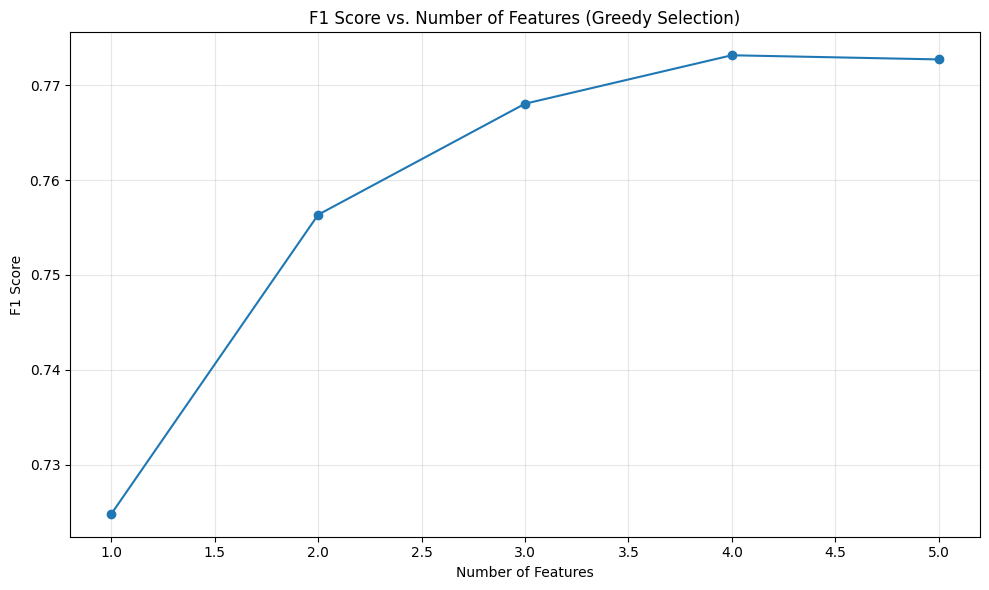

([['Basic'],
  ['Basic', 'Context_Words'],
  ['Basic', 'Context_Words', 'Context_POS'],
  ['Basic', 'Context_Words', 'Context_POS', 'Lemmas'],
  ['Basic', 'Context_Words', 'Context_POS', 'Lemmas', 'Specific']],
 [0.7247995418098511,
  0.7563625965112953,
  0.7680727169436159,
  0.7731856270416133,
  0.7727466288147623],
  <nltk.tag.crf.CRFTagger at 0x2776d8d12d0>])

In [ ]:
# Tarda 40 minutos en ejecutarse

######################### HACERLO CON DATOS DE VALIDACION #########################
train_completo()

## 10. Full Analysis with Optimized Features

Now that we've identified the best feature combinations, we can train a model with the optimal configuration and evaluate it on the full test set.

Buscamos los mejores features a base de addición, y lo avaluamos con los datos de validación, posteriormente obtenemos el modelo con mejor score F1 y lo predecimos para los datos test como validación del modelo.

In [ ]:
# Example of running a complete analysis with the optimal feature configuration
def run_optimal_configuration(model_path=None, preprocessed_test = None, train_tags = None):
    """
    Run a complete analysis with the optimal feature configuration.
    
    Args:
        model_path: Optional path to a pre-trained model file. If provided, the model will be loaded
                   instead of being trained. For example: 'best_model_r4_B_C_C_L.crf.tagger'
    
    Returns:
        A tuple containing (tagger, evaluation_results)
    """
    # Create feature function with optimal settings (based on our findings)
    optimal_feat_func = OptimizedFeatFunc(
        use_Basic=True,
        use_context_words=True, 
        use_contex_POS_tag=True,
        use_lemas=True,  # Including lemmatization
        use_specific_caracteristics=True
    )
    
    # Initialize CRF tagger with our feature function
    optimal_tagger = CRFTagger(feature_func=optimal_feat_func)

    if train_tags is not None:

        optimal_tagger.train(train_tags, 'TAGS{}_model.crf.tagger')
    
    print(f"Loading pre-trained model from {model_path}...")
        # Load the model instead of training
    optimal_tagger.set_model_file(model_path)
    
    print("Evaluating model on test data...")
    # Evaluate using entity-level metrics
    entity_results = entity_level_accuracy(optimal_tagger, preprocessed_test)
    
    print("\n=== Entity-Level Evaluation Results ===")
    print(f"Precision: {entity_results['precision']:.4f}")
    print(f"Recall: {entity_results['recall']:.4f}")
    print(f"F1 Score: {entity_results['f1']:.4f}")
    
    return entity_results

# Example usage:
# To load the pre-trained best model:
best_model_path = 'best_model_r4_B_C_C_L.crf.tagger'
results = run_optimal_configuration(model_path=best_model_path, preprocessed_test=preprocessed_test)

# Or to train a new model:
# optimal_tagger, results = run_optimal_configuration()

Loading pre-trained model from best_model_r4_B_C_C_L.crf.tagger...
Evaluating model on test data...

=== Entity-Level Evaluation Results ===
Precision: 0.7815
Recall: 0.7650
F1 Score: 0.7732


## 6. Experiment with Different Tag Encoding Schemes

The BIO scheme is the most common, but let's implement functions to convert to other schemes.

In [ ]:
def bio_to_io(tagged_sent: List[Tuple[str, str, str]]) -> List[Tuple[str, str, str]]:
    """Convert BIO tagging to IO tagging
    
    Args:
        tagged_sent: List of tuples where each tuple contains (word, pos, tag) in BIO format.
        
    Returns:
        List of tuples where each tuple contains (word, pos, tag) in IO format.
    """
    io_sent = []
    for word, pos, tag in tagged_sent:
        if tag == "O":
            io_sent.append((word, pos, tag))
        else:
            # Replace B- with I- for any entity tag
            entity_type = tag[2:]
            io_sent.append((word, pos, f"I-{entity_type}"))
    return io_sent

def bio_to_bioes(sent: List[Tuple[str, str, str]]) -> List[Tuple[str, str, str]]:
    """Convert BIO tagging to BIOES tagging
    Args:
        tagged_sent: List of tuples where each tuple contains (word, pos, tag) in BIO format.
        """
    new_sent = []
    n = len(sent)
    i = 0
    
    while i < n:
        word, pos, tag = sent[i]
        
        if tag == "O":
            new_sent.append((word, pos, tag))
            i += 1
        elif tag.startswith("B-"):
            entity_type = tag[2:]
            
            # Check if it's a singleton entity (no following I- tags)
            if i + 1 == n or not sent[i+1][2].startswith(f"I-{entity_type}"):
                new_sent.append((word, pos, f"S-{entity_type}"))
                i += 1
            else:
                # It's the beginning of a multi-token entity
                new_sent.append((word, pos, f"B-{entity_type}"))
                i += 1
                
                # Process all the intermediate I- tags
                while i < n and sent[i][2] == f"I-{entity_type}":
                    # Check if this is the last I- tag
                    if i + 1 == n or sent[i+1][2] != f"I-{entity_type}":
                        new_sent.append((sent[i][0], sent[i][1], f"E-{entity_type}"))
                    else:
                        new_sent.append((sent[i][0], sent[i][1], f"I-{entity_type}"))
                    i += 1
        else:
            # Handle unexpected tags (like I- without preceding B-)
            new_sent.append((word, pos, tag))
            i += 1
            
    return new_sent

def bio_to_bioe(sent: List[Tuple[str, str, str]]) -> List[Tuple[str, str, str]]:
    """Convert BIO tagging to BIOE tagging (BIOE includes E to indicate the end of an entity)
    Args:
        tagged_sent: List of tuples where each tuple contains (word, pos, tag) in BIO format.
        """
    new_sent = []
    n = len(sent)
    i = 0
    while i < n:
        word, pos, tag = sent[i]
        entity_type = tag[2:]
      
        if tag[:2] == 'B-':
            new_sent.append((word, pos, f'B-{entity_type}'))
            i += 1
            while i < n and sent[i][2] == f'I-{entity_type}':
                # Is it the last I-?
                if i + 1 == n or sent[i+1][2] != f'I-{entity_type}':
                    new_sent.append((sent[i][0], sent[i][1], f'E-{entity_type}'))
                else:
                    new_sent.append((sent[i][0], sent[i][1], f'I-{entity_type}'))
                i += 1
        else:
            new_sent.append((word, pos, tag))
            i += 1
    return new_sent

def bio_to_biow(sent: List[Tuple[str, str, str]]) -> List[Tuple[str, str, str]]:
    """Convert BIO tagging to BIOW tagging (BIOW includes W to indicate single-token entities)
    Args:
        tagged_sent: List of tuples where each tuple contains (word, pos, tag) in BIO format.
        """
    new_sent = []
    n = len(sent)
    for i, (word, pos, chunk) in enumerate(sent):
        if chunk[:2] == "B-":
            if ((i+1) == n) or (not sent[i+1][2][:2] == "I-"):
                new_chunk = "W-" + chunk[2:]
            else:
                new_chunk = chunk
        else:
            new_chunk = chunk
        new_sent.append((word, pos, new_chunk))
    return new_sent

def bio_to_bioes(sent: List[Tuple[str, str, str]]) -> List[Tuple[str, str, str]]:
    """Convert BIO tagging to BIOES tagging (BIOES includes E to indicate the end of an entity and S for single-token entities)
    Args:
        tagged_sent: List of tuples where each tuple contains (word, pos, tag) in BIO format.
        """
    new_sent = []
    n = len(sent)
    i = 0
    while i < n:
        word, pos, tag = sent[i]
        entity_type = tag[2:]
      
        if tag[:2] == 'B-':
            # Check if it is a single-token entity
            if i + 1 == n or sent[i+1][2][:2] != "I-":
                new_sent.append((word, pos, f'S-{entity_type}'))
                i += 1
            else:
                new_sent.append((word, pos, f'B-{entity_type}'))
                i += 1
                while i < n and sent[i][2] == f'I-{entity_type}':
                    # Is it the last I-?
                    if i + 1 == n or sent[i+1][2] != f'I-{entity_type}':
                        new_sent.append((sent[i][0], sent[i][1], f'E-{entity_type}'))
                    else:
                        new_sent.append((sent[i][0], sent[i][1], f'I-{entity_type}'))
                    i += 1
        else:
            new_sent.append((word, pos, tag))
            i += 1
    return new_sent

# Example of converting tags
sample_sent = train[5]  # Get a sentence that hopefully has some entities
print("Original (BIO):")
print(sample_sent)

io_sent = bio_to_io(sample_sent)
print("\nIO Scheme:")
print(io_sent)

bioes_sent = bio_to_bioes(sample_sent)
print("\nBIOES Scheme:")
print(bioes_sent)

In [ ]:
## hay que guardar los modelos de tags y las salidas.
def test_with_othersCodes():
    Codes = ['BIO', 'IO', 'BIOE', 'BIOES', 'BIOW']
    test_entities = extract_entities(test)
    for i in Codes[1:]:
        if i == 'IO':
            train_tag = bio_to_io(train)
        if i == 'BIOE':
            train_tag = bio_to_bioe(train)
        if i == 'BIOES':
            train_tag = bio_to_bioes(train)
        if i == 'BIOW':
            train_tag = bio_to_biow(train)
        # Train the model with the new tagging scheme
        resultados_tags = run_optimal_configuration(model_path=best_model_path, preprocessed_test=preprocessed_test, train_tags=train_tag)
        print(f"\nResults for {i} tagging scheme:")
        print(f"Precision: {resultados_tags['precision']:.4f}")
        print(f"Recall: {resultados_tags['recall']:.4f}")
        print(f"F1 Score: {resultados_tags['f1']:.4f}")

############################################## COMPARAR LOS ENTITIES PREDICHOS CON test_entities ##############################
    
# Example usage
test_with_othersCodes()


## Conclusion

In this notebook, we've demonstrated:

1. How to use the custom `data` class to process NER data and extract lemmas
2. Implementing a feature function class with various customizable feature sets
3. Training and evaluating CRF models for NER with different feature combinations
4. Converting between different tagging schemes (BIO, IO, BIOES)
5. Entity-level evaluation for more accurate performance measurement
6. Systematic analysis of feature importance for NER performance

The entity-level evaluation provides a more meaningful assessment of NER performance than token-level accuracy, as it ensures that complete entities are correctly identified rather than just individual tokens.